In [983]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from category_encoders import TargetEncoder, CountEncoder
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.cluster import KMeans

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import shap
import warnings
warnings.filterwarnings("ignore")

In [984]:
train_df = pd.read_csv('training_dataset.csv')
test_df = pd.read_csv('validation_set.csv')

In [985]:
train_set, val_set = train_test_split(
    train_df, test_size = 0.2,
    random_state = 43,
    stratify = train_df['berlangganan_deposito'])

In [986]:
from sklearn.calibration import LabelEncoder


encoder1 = CountEncoder()
encoder2 = CountEncoder()
encoder_kerja = CountEncoder()

def apply_count_encoding(df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    ret = df.copy()
    if train:
        ret['jenis_kontak'] = encoder1.fit_transform(ret['jenis_kontak'])
        ret['kelompok_usia'] = encoder2.fit_transform(ret['kelompok_usia'])
        ret['pekerjaan'] = encoder_kerja.fit_transform(ret['pekerjaan'])
        # ret['hari_kontak_terakhir'] = encoder3.fit_transform(ret['hari_kontak_terakhir'])
    else:
        ret['jenis_kontak'] = encoder1.transform(ret['jenis_kontak'])
        ret['kelompok_usia'] = encoder2.transform(ret['kelompok_usia'])
        ret['pekerjaan'] = encoder_kerja.transform(ret['pekerjaan'])
     
    return ret

In [987]:
encoder3 = LabelEncoder()
def apply_label_encoding(df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    ret = df.copy()
    if train:
        ret['hari_kontak_terakhir'] = encoder3.fit_transform(ret['hari_kontak_terakhir'])
    else:
        ret['hari_kontak_terakhir'] = encoder3.transform(ret['hari_kontak_terakhir'])
    return ret

In [988]:
scaler = StandardScaler()
def apply_scale(df: pd.DataFrame, train:bool = False) -> pd.DataFrame:
  cols = [col for col in df.columns if col != "berlangganan_deposito" and df[col].dtype in [np.float64, np.int64]]
  ret = df.copy()
  if train:
    ret[cols] = scaler.fit_transform(df[cols])
  else:
    ret[cols] = scaler.transform(df[cols])
  return ret

In [989]:
def apply_fe(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()
    # ret['jumlah_pekerja_x_tingkat_variasi'] = ret['jumlah_pekerja'] * ret['tingkat_variasi_pekerjaan']
    # ret['jumlah_pekerja_x_suku_bunga'] = ret['jumlah_pekerja'] * ret['suku_bunga_euribor_3bln']
    # ret['jumlah_pekerja_x_ihk'] = ret['jumlah_pekerja'] * ret['indeks_harga_konsumen']
    # ret['ratio_1'] = 1/(ret['jumlah_pekerja_x_tingkat_variasi'] + 1e6)
    # ret['ratio_2'] = 1/(ret['jumlah_pekerja_x_suku_bunga'] + 1e6)
    # ret['ratio_3'] = 1/(ret['jumlah_pekerja_x_ihk'] + 1e6)
    ret['volatilitas'] = ret['tingkat_variasi_pekerjaan'] * ret['indeks_harga_konsumen']
    ret['stability'] = 1 / (ret['volatilitas'] + 1e-6)
    # ret['volatilitas_log'] = np.log1p(ret['volatilitas']+ 1e-6)
    # ret['stability_log'] = np.log1p(ret['stability']+1e-6)
    bins = [0, 25, 40, 60, 100]
    labels = ['Gen-Z', 'Millenial', 'Gen-X', 'Boomer']
    ret['kelompok_usia'] = pd.cut(ret['usia'], bins=bins, labels=labels)
    # ret['feat1'] = (ret['gagal_bayar_sebelumnya'] == 'no') & (ret['jenis_kontak'] == 'cellular')
    # ret['feat2'] = (ret['pinjaman_rumah'] == 'unknown') & (ret['pinjaman_pribadi'] == 'unknown')
    # ret['feat3'] = (ret['pinjaman_rumah'] == 'no') & (ret['pinjaman_pribadi'] == 'no')
    # ret['feat4'] = (ret['pekerjaan'] == 'pensiunan') & (ret['gagal_bayar_sebelumnya'] == 'no')
    # ret['feat5'] = (ret['pekerjaan'] == 'pensiunan') & (ret['jenis_kontak'] == 'cellular')
    ret['feat6'] = (ret['pekerjaan'] == 'pensiunan') & \
                    (ret['gagal_bayar_sebelumnya'] == 'no') & \
                    (ret['jenis_kontak'] == 'cellular')
    ret['jumlah_pekerja_log'] = np.log1p(ret['jumlah_pekerja'] + 1e-6)
    # ret['suku_bunga_euribor_3bln_log'] = np.log1p(ret['suku_bunga_euribor_3bln'] + 1e-6)
    # ret['jumlah_pekerja_sq'] = ret['jumlah_pekerja'] ** 2
    # ret['suku_bunga_euribor_3bln_sq'] = ret['suku_bunga_euribor_3bln'] ** 2
    
    
    ret['interaksi_kontak_terakhir'] = ret['jumlah_kontak_kampanye_ini'] / (ret['hari_kontak_terakhir'] + 1) 
    # ret['indeks'] = np.abs(ret['indeks_harga_konsumen']*ret['indeks_kepercayaan_konsumen'])
    ret['sb_x_ikk'] = ret['suku_bunga_euribor_3bln'] * ret['indeks_kepercayaan_konsumen']
    ret['ikk'] = 1/ret['indeks_kepercayaan_konsumen'] + 1e-6
    # ret['sb_x_ikk_inverse'] = 1 / (ret['sb_x_ikk'] + 1e-6)
    # ret['tv_x_ikk'] = ret['tingkat_variasi_pekerjaan'] * ret['indeks_kepercayaan_konsumen']
    # ret['jp_x_ikk'] = ret['jumlah_pekerja'] * ret['indeks_kepercayaan_konsumen']
    return ret


In [990]:
encoder4 = TargetEncoder()
def apply_indeks(df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    ret = df.copy()
    # ret['indeks_harga_konsumen'] = ret['indeks_harga_konsumen'].astype(str)
    # if train:
    #     ret['indeks_1'] = encoder3.fit_transform(ret['indeks_harga_konsumen'], ret['jumlah_pekerja'])
    # else:
    #     ret['indeks_1'] = encoder3.transform(ret['indeks_harga_konsumen'])
    return ret

    

In [991]:
ohe = OneHotEncoder(
    categories='auto',
    drop='first',  
    sparse_output=False,  
    handle_unknown='ignore'  
)
def apply_sukses(df, is_train):
    ret = df.copy()
    if is_train:
        encoded_fuel = ohe.fit_transform(ret[['hasil_kampanye_sebelumnya']])
    else:
        encoded_fuel = ohe.transform(ret[['hasil_kampanye_sebelumnya']])
    
    features = ohe.get_feature_names_out(['hasil_kampanye_sebelumnya'])
    encoded_df = pd.DataFrame(encoded_fuel, columns=features, index=ret.index)
    
    ret = pd.concat([ret, encoded_df], axis=1)
    ret = ret.drop(columns=['hasil_kampanye_sebelumnya'])
    return ret


In [992]:
kpca = KernelPCA(n_components=1, kernel='rbf', gamma=1)  

def apply_kpca(df: pd.DataFrame, train: bool = False) -> pd.DataFrame:
    ret = df.copy()
    cols = ['tingkat_variasi_pekerjaan', 'suku_bunga_euribor_3bln', 'jumlah_pekerja']
    if train:
        kpca_result = kpca.fit_transform(ret[cols])
        kpca_cols = ['kpca_1']
        ret = ret.drop(columns=cols)
        ret[kpca_cols] = kpca_result
    else:
        kpca_result = kpca.transform(ret[cols])
        kpca_cols = ['kpca_1']
        ret = ret.drop(columns=cols)
        ret[kpca_cols] = kpca_result
    return ret


In [993]:
pca = PCA(n_components=1)
def apply_pca(df: pd.DataFrame, train: bool = False) -> pd.DataFrame:
    ret = df.copy()
    cols = ['tingkat_variasi_pekerjaan', 'suku_bunga_euribor_3bln', 'jumlah_pekerja']
    if train:
        pca_result = pca.fit_transform(ret[cols])
        pca_cols = ['pca_1']

        ret = ret.drop(columns=cols)
        ret[pca_cols] = pca_result
    else:
        pca_result = pca.transform(ret[cols])
        pca_cols = ['pca_1']
        ret = ret.drop(columns=cols)
        ret[pca_cols] = pca_result
    return ret

In [994]:
def apply_high_season(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()
    ret['high_season'] = ret['bulan_kontak_terakhir'].apply(lambda x: 1 if x in ['oct', 'mar', 'sep', 'apr', 'dec'] else 0)
    return ret

In [995]:
class CustomPipeline:
    
    def fit_transform(X: pd.DataFrame, y: pd.Series) -> tuple:
        ret = pd.concat([X, y], axis=1)
        ret = apply_label_encoding(ret, True)
        ret = apply_sukses(ret, True)
        ret = apply_fe(ret)
        ret = apply_count_encoding(ret, True)
        ret = apply_high_season(ret)
        ret = apply_indeks(ret, True)
        ret.drop(columns=['customer_number', 'usia', 'pekerjaan', 'status_perkawinan',
       'pendidikan', 'gagal_bayar_sebelumnya', 'pinjaman_rumah',
       'pinjaman_pribadi', 'bulan_kontak_terakhir', 'jumlah_kontak_kampanye_ini',
       'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya',
       'indeks_harga_konsumen', 'pulau', 'indeks_kepercayaan_konsumen'], inplace=True)
        ret = apply_scale(ret, True)
        ret = apply_pca(ret, True)
        return (ret.drop(columns=["berlangganan_deposito"]), ret["berlangganan_deposito"])

    def transform(df: pd.DataFrame) -> pd.DataFrame:
        ret = df.copy()
        ret = apply_label_encoding(ret, False)
        ret = apply_sukses(ret, False)
        ret = apply_fe(ret)
        ret = apply_count_encoding(ret, False)
        ret = apply_high_season(ret)
        ret = apply_indeks(ret, False)
        ret.drop(columns=['customer_number', 'usia', 'pekerjaan', 'status_perkawinan',
       'pendidikan', 'gagal_bayar_sebelumnya', 'pinjaman_rumah',
         'pinjaman_pribadi', 'bulan_kontak_terakhir','jumlah_kontak_kampanye_ini',
         'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya',
         'indeks_harga_konsumen', 'pulau', 'indeks_kepercayaan_konsumen'], inplace=True)
        ret = apply_scale(ret, False)
        ret = apply_pca(ret, False)
        return ret

In [996]:


def run_kfold_cv(model, df, n_splits=5, random_state=42):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    metrics = {
        'roc_auc': [],
    }
    for fold, (train_idx, val_idx) in enumerate(kf.split(df, df['berlangganan_deposito']), 1):
        train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = train_df['berlangganan_deposito'], val_df['berlangganan_deposito']
        
        
        X_train = train_df.drop(columns=['berlangganan_deposito'])
        X_val = val_df.drop(columns=['berlangganan_deposito'])

        X_train_transformed, y_train = CustomPipeline.fit_transform(X_train, y_train)
        X_val_transformed = CustomPipeline.transform(X_val)

        model.fit(X_train_transformed, y_train)

        y_val_pred = model.predict_proba(X_val_transformed)[:, 1]

        roc_auc = roc_auc_score(y_val, y_val_pred)
        metrics['roc_auc'].append(roc_auc)

        print(f"Fold {fold} ROC AUC: {roc_auc:.4f}")

    avg_roc_auc = np.mean(metrics['roc_auc'])
    std_roc_auc = np.std(metrics['roc_auc'])
    

    print("\n=== ROC AUC Scores Across Folds ===")
    print([f"{score:.4f}" for score in metrics['roc_auc']])
    print(f"Average ROC AUC: {avg_roc_auc:.4f} ± {std_roc_auc:.4f}")



# model = RandomForestClassifier(random_state=42)
# model = GradientBoostingClassifier( n_estimators=300,
#     learning_rate=0.05,
#     max_depth=4,
#     subsample=0.8,
#     min_samples_leaf=5,
#     max_features='sqrt',
#     validation_fraction=0.1,
#     n_iter_no_change=10,
#     random_state=42)
# model = LGBMClassifier()
# model = XGBClassifier()
# model = CatBoostClassifier()
# model = AdaBoostClassifier()
# model = LogisticRegression()
# model = DecisionTreeClassifier()
# model = KNeighborsClassifier()
# model = StackingClassifier(estimators=[
#     ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
#     ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
#     ('xgb', XGBClassifier()),
#     ('cat', CatBoostClassifier()),
#     ('lgbm', LGBMClassifier()),
#     ('ada', AdaBoostClassifier()),
#     ('logreg', LogisticRegression()),
#     ('dt', DecisionTreeClassifier())
# ], final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

# model = VotingClassifier(
#     estimators=[
#         ('lgbm', LGBMClassifier()),
#         ('xgb', XGBClassifier()),
#         ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
#     ],
#     voting='soft'  # Place this INSIDE the parentheses
# )


model = StackingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier()),
        ('xgb', XGBClassifier()),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
        
    ],
    final_estimator=LogisticRegression(),
    cv=3
)
# model = SVC(probability=True, random_state=42)
# model = BalancedRandomForestClassifier(random_state=42, class_weight='balanced')
run_kfold_cv(model, train_df, n_splits=5, random_state=42)

[LightGBM] [Info] Number of positive: 2091, number of negative: 16241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 18332, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114063 -> initscore=-2.049896
[LightGBM] [Info] Start training from score -2.049896
[LightGBM] [Info] Number of positive: 1394, number of negative: 10827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 12221, number of used features: 14
[LightGBM] [Info] [bin

=== ROC AUC Scores Across Folds ===
['0.7879', '0.8111', '0.8118', '0.8007', '0.7979']
Average ROC AUC: 0.8019 ± 0.0089

[LightGBM] [Info] Number of positive: 2091, number of negative: 16241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 18332, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114063 -> initscore=-2.049896
[LightGBM] [Info] Start training from score -2.049896
[LightGBM] [Info] Number of positive: 1394, number of negative: 10827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 12221, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114066 -> initscore=-2.049866
[Light

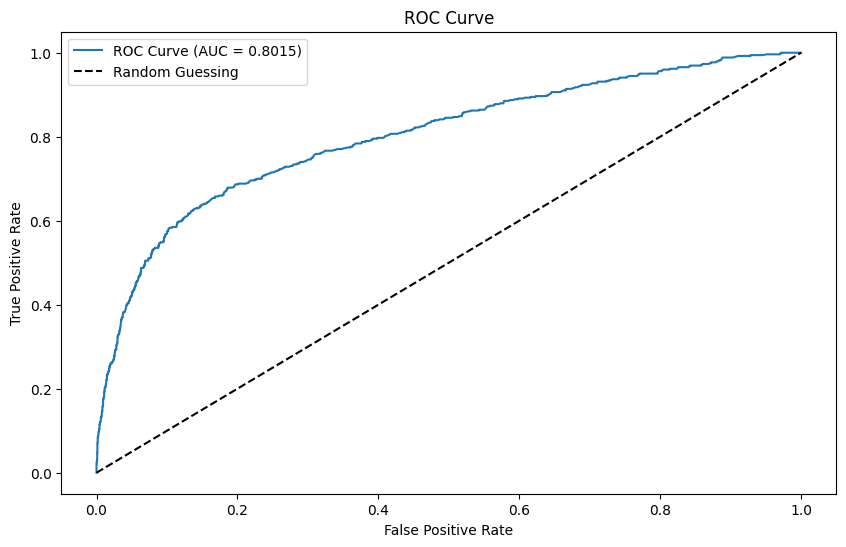

In [998]:
X_train = train_set.drop(columns=["berlangganan_deposito"])
y_train = train_set["berlangganan_deposito"]

(X_train, y_train) = CustomPipeline.fit_transform(X_train, y_train)
X_val = val_set.drop(columns=["berlangganan_deposito"])
y_val = val_set["berlangganan_deposito"]

X_val = CustomPipeline.transform(X_val)

model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC: {roc_auc:.4f}")
# f1 score, precision, recall, confusion matrix
print(f"Validation F1 Score: {f1_score(y_val, (y_val_pred > 0.5).astype(int)):.4f}")
print(f"Validation Precision: {precision_score(y_val, (y_val_pred > 0.5).astype(int)):.4f}")
print(f"Validation Recall: {recall_score(y_val, (y_val_pred > 0.5).astype(int)):.4f}")
#pr auc
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [999]:
import pickle
import os # To manage file paths

# Assume 'model' is your trained StackingClassifier instance
# For example, if you've run model.fit(X_train_transformed, y_train)
# outside of the CV loop or after the final CV iteration

# Define the filename for your saved model
model_filename = 'stacking_classifier_model.pkl'

# Save the model
try:
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model successfully saved to {model_filename}")
except Exception as e:
    print(f"Error saving model: {e}")

Model successfully saved to stacking_classifier_model.pkl


In [997]:


# X_train = train_set.drop(columns=["berlangganan_deposito"])
# y_train = train_set["berlangganan_deposito"]
# X_test = val_set.drop(columns=["berlangganan_deposito"])
# y_test = val_set["berlangganan_deposito"]
# # X_train, y_train = CustomPipeline.fit_transform(X_train, y_train)
# (X_train, y_train) = CustomPipeline.fit_transform(X_train, y_train)
# X_test = CustomPipeline.transform(X_test)

# model.fit(X_train, y_train)
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer(X_train, check_additivity=False)

# shap.summary_plot(shap_values, X_train)
# shap.plots.force(shap_values[0])
